# Segmentation Map

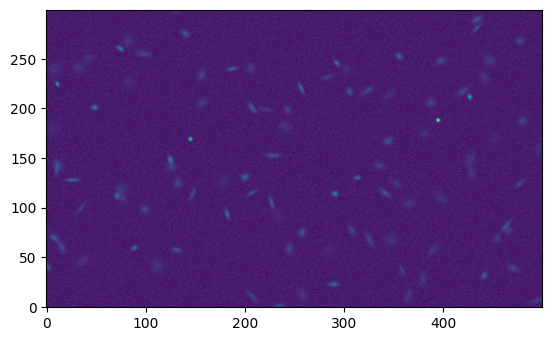

In [1]:
# Start by creating a synthetic image
from photutils.datasets import make_100gaussians_image
data = make_100gaussians_image()


# show plots along the way
from matplotlib.pyplot import imshow
imshow(data, origin='lower')

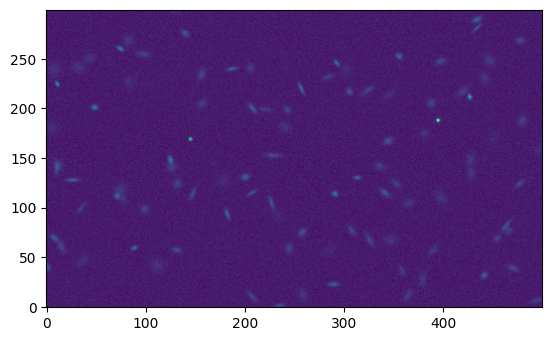

In [2]:
# subtract background from the data; the input array should always be background subtracted
from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50,50), filter_size=(3,3), bkg_estimator=bkg_estimator)
data -= bkg.background
imshow(data, origin='lower')

In [3]:
# Determine a threshold value
threshold = 1.5 * bkg.background_rms

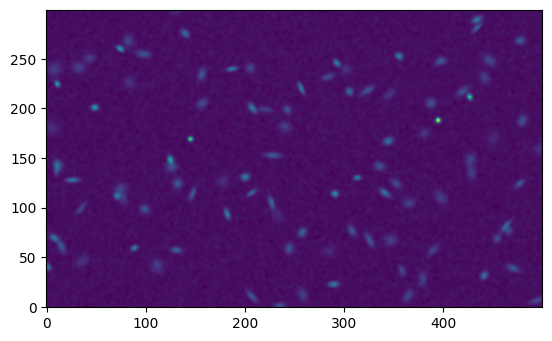

In [4]:
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
kernel = make_2dgaussian_kernel(3.0, 5)
convolved_data = convolve(data, kernel)
imshow(convolved_data, origin='lower')

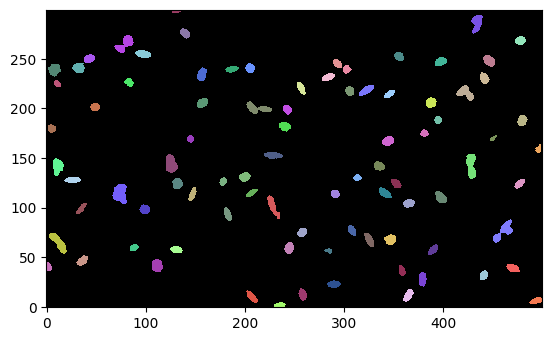

In [5]:
from photutils.segmentation import detect_sources
segment_map = detect_sources(convolved_data, threshold, npixels=10)

imshow(segment_map, cmap=segment_map.cmap, origin='lower', interpolation='nearest')

# Stange colors at object edges appears to be an artifact, next cell shows a cleaner image

Text(0.5, 1.0, 'Segmentation Image')

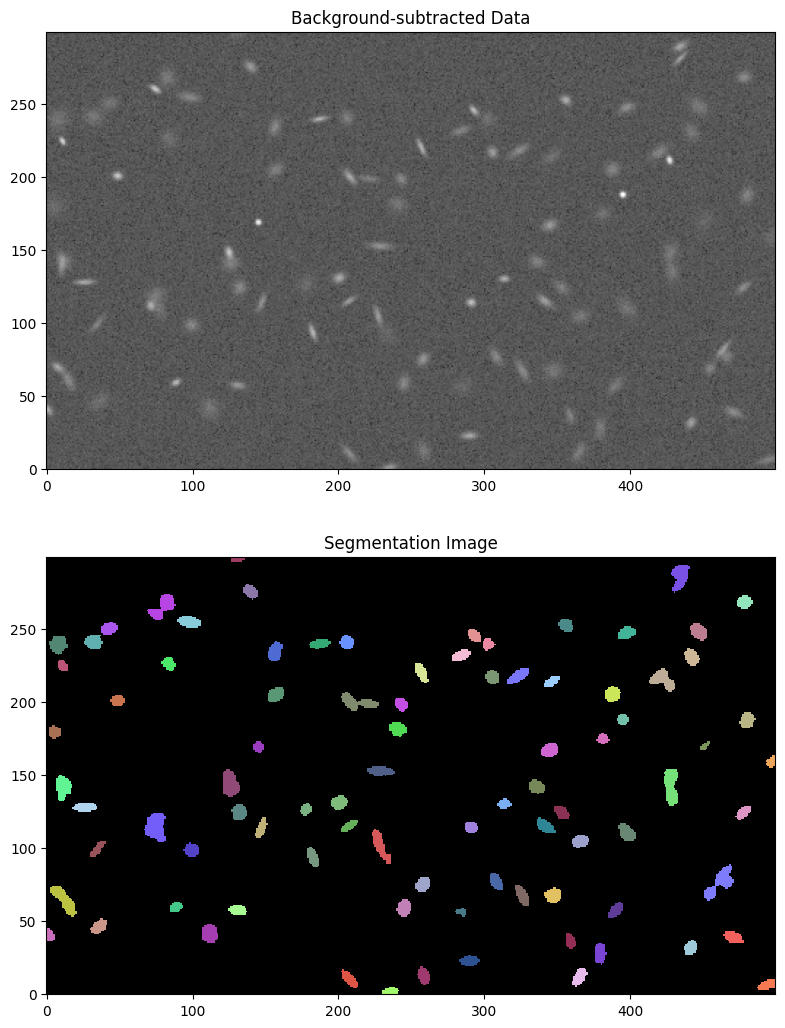

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Background-subtracted Data')
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')

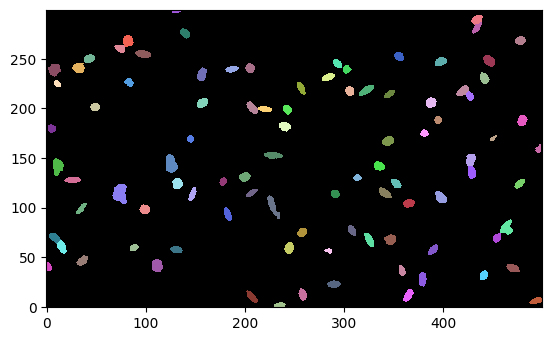

In [7]:
from photutils.segmentation import deblend_sources
segm_deblend = deblend_sources(convolved_data, segment_map, npixels=10, nlevels=32, contrast=0.001, progress_bar=False)

imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap, interpolation='nearest')

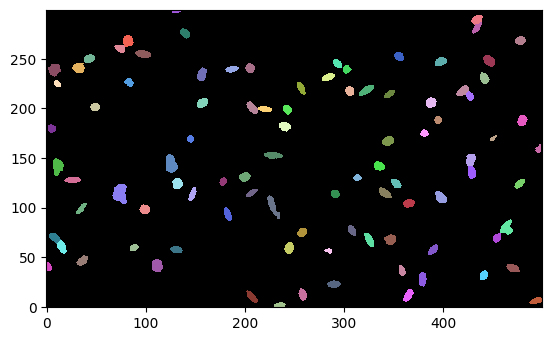

In [8]:
# The SourceFinder class is convenient for this sort of segmentation and deblending
from photutils.segmentation import SourceFinder
finder = SourceFinder(npixels=10, progress_bar=False)
found_seg_map = finder(convolved_data, threshold)
imshow(found_seg_map, cmap=found_seg_map.cmap, interpolation='nearest', origin='lower')

## SourceCatalog

In [9]:
# The SourceCatalog class gives photometry, centroid, and morphology information
from photutils.segmentation import SourceCatalog
cat = SourceCatalog(data, segm_deblend, convolved_data=convolved_data)
print(cat)

<photutils.segmentation.catalog.SourceCatalog>
Length: 94
labels: [ 1  2  3  4  5 ... 90 91 92 93 94]


In [10]:
# Source properties can be accessed as SourceCatalog attributes or output to an astropy table
tbl = cat.to_table()
tbl["xcentroid"].info.format =".2f"
tbl["ycentroid"].info.format =".2f"
tbl["kron_flux"].info.format =".2f"
print(tbl)

label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
----- --------- --------- ... --------------- --------- ------------
    1    235.31      1.45 ...             nan    509.74          nan
    2    493.92      5.79 ...             nan    544.31          nan
    3    207.42      9.81 ...             nan    722.26          nan
    4    364.86     11.11 ...             nan    704.23          nan
    5    258.27     11.94 ...             nan    661.22          nan
    6    289.52     22.32 ...             nan    863.94          nan
    7    379.16     27.35 ...             nan    734.26          nan
    8    441.31     31.18 ...             nan    745.13          nan
    9    358.54     35.88 ...             nan    492.43          nan
   10    111.77     40.99 ...             nan    914.06          nan
  ...       ...       ... ...             ...       ...          ...
   85    428.24    135.24 ...     

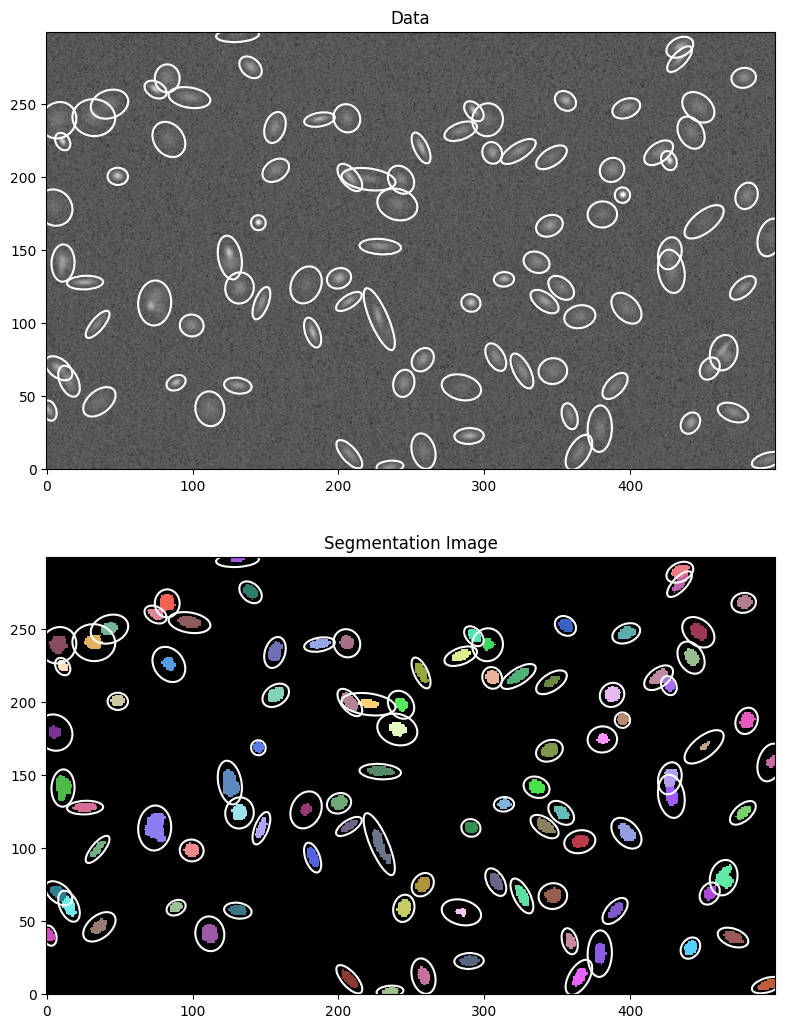

In [11]:
# exmaple of kron aperture calculatio
from astropy.visualization import simple_norm
norm = simple_norm(data, 'sqrt')

# Plot figures
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
ax2.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')

# Plot Kron apertures
cat.plot_kron_apertures(ax=ax1, color='white', lw=1.5);
cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5);

In [12]:
# The catalog can be filtered by label number in the segmentation image
labels = [1, 5, 20, 50, 75, 80]
cat_subset = cat.get_labels(labels)
tbl2 = cat_subset.to_table()
tbl2['xcentroid'].info.format = '.2f'
tbl2['ycentroid'].info.format = '.2f'
tbl2['kron_flux'].info.format = '.2f'
print(tbl2)

label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
----- --------- --------- ... --------------- --------- ------------
    1    235.31      1.45 ...             nan    509.74          nan
    5    258.27     11.94 ...             nan    661.22          nan
   20    346.99     66.83 ...             nan    811.70          nan
   50      5.29    178.94 ...             nan    614.46          nan
   75     42.96    249.88 ...             nan    617.18          nan
   80    130.75    297.10 ...             nan    246.91          nan


In [13]:
# to_table method assumes a few default columns; These columns can be user-defined
columns = ["label", "xcentroid", "ycentroid", "area", "segment_flux"]
tbl3 = cat_subset.to_table(columns=columns)
tbl3['xcentroid'].info.format = '.2f'
tbl3['ycentroid'].info.format = '.2f'
print(tbl3)

label xcentroid ycentroid area    segment_flux   
                          pix2                   
----- --------- --------- ---- ------------------
    1    235.31      1.45 47.0  445.6094723471697
    5    258.27     11.94 79.0  472.4108676113713
   20    346.99     66.83 98.0   571.313836037895
   50      5.29    178.94 57.0  257.4050405384048
   75     42.96    249.88 79.0   428.712159927771
   80    130.75    297.10 25.0 108.78767615532281


In [15]:
# While the input array should always be background subtracted, the background can
# be given seperately. Then, SourceCatalog can give information on the background too.

bkg_cat = SourceCatalog(data, segm_deblend, background=bkg.background)
bkg_subset = bkg_cat.get_labels(labels)

bkg_columns = ['label', 'background_centroid', 'background_mean', 'background_sum']
tbl4 = bkg_subset.to_table(columns=bkg_columns)
print(tbl4)

label background_centroid  background_mean     background_sum  
----- ------------------- ------------------ ------------------
    1   5.203196494193413  5.202613749383417 244.52284622102061
    5     5.2369908637168   5.22297434348533   412.614973135341
   20   5.239299950956021  5.270209454696801  516.4805265602864
   50   5.191006932734081 5.2466148917725635  299.0570488310361
   75   5.201073600517763  5.224984475630104  412.7737735747782
   80   5.266956236991319  5.264219782920205 131.60549457300513
